In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from os.path import join, dirname
import os

import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import itertools
import pickle
import scipy
from IPython.display import display, Markdown, Latex

from plot_utils import lighten_boxplot
import admix

In [2]:
geno_sim_prefix = "EUR_0.2_AFR_0.8_7_80000"
geno_data_dir = f"data/geno/{geno_sim_prefix}/"

anc = np.load(join(geno_data_dir, "anc.npy"))
phgeno = np.load(join(geno_data_dir, "phgeno.npy"))
legend = pd.read_csv(join(geno_data_dir, "legend.csv"))

n_indiv = anc.shape[0] // 2
n_snp = anc.shape[1]
anc = anc.reshape(n_indiv, n_snp * 2)
phgeno = phgeno.reshape((n_indiv, n_snp * 2))
geno = admix.convert_anc_count(anc=anc, phgeno=phgeno)

# Allele frequency

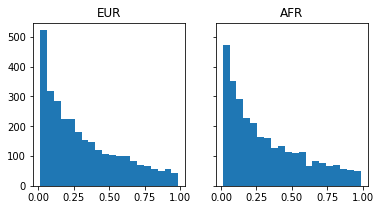

In [3]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True)
axs[0].hist(legend.EUR.values, bins=20)
axs[0].set_title("EUR")
axs[1].hist(legend.AFR.values, bins=20)
axs[1].set_title("AFR")
plt.show()

In [4]:
control_ratio_list = [1.0, 2.5]
odds_ratio_list = [1.0, 1.15, 1.2, 1.25]
score_df_dict = {control_ratio: dict() for control_ratio in control_ratio_list}

for control_ratio in control_ratio_list:
    rls_dir = f"out/single_snp_test_tractor/{geno_sim_prefix}/0.1_{control_ratio}/"

    for odds_ratio in odds_ratio_list:
        score_df_dict[control_ratio][odds_ratio] = pd.read_csv(join(rls_dir, f"{odds_ratio}_0.0", "summary.csv.gz"))

# Null simulation

## Control ratio: 1.0

ADM              0.039952
ATT              0.050173
MIX              0.049791
SNP1             0.048588
SUM              0.043127
ADM_LOGISTIC     0.051194
ATT_LOGISTIC     0.049985
SNP1_LOGISTIC    0.050200
TRACTOR          0.051347
dtype: float64


## Control ratio: 2.5

ADM              0.039937
ATT              0.049731
MIX              0.049376
SNP1             0.047925
SUM              0.042847
ADM_LOGISTIC     0.051328
ATT_LOGISTIC     0.049592
SNP1_LOGISTIC    0.049446
TRACTOR          0.049737
dtype: float64


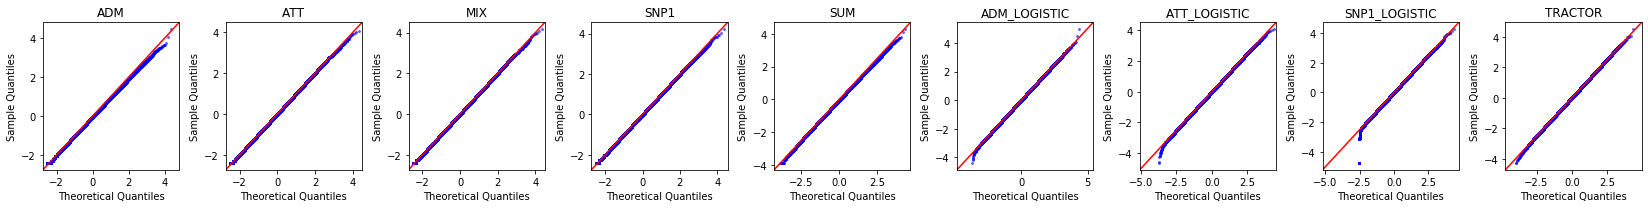

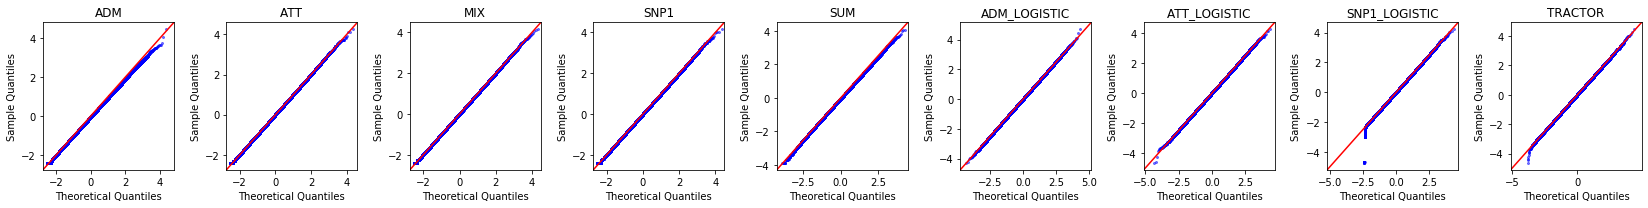

In [5]:
for control_ratio in control_ratio_list:
    display(Markdown(f"## Control ratio: {control_ratio}"))
    score_df = score_df_dict[control_ratio][1.0].copy().dropna()
    pval_df = score_df.iloc[:, 0:-2].copy()

    qq_fig, qq_axs = plt.subplots(1, pval_df.shape[1], figsize=(23,3))
    for col_i, col in enumerate(pval_df.columns):
        zsc = admix.pval2zsc(pval_df[col].values)
        sm.qqplot(zsc, line="45", markersize=2, alpha=0.5, ax=qq_axs[col_i])
        qq_axs[col_i].set_title(col)
    plt.tight_layout()

    print(np.mean(pval_df < 0.05, axis=0))

# Power simulation

# Main figure

Number of differentiated SNPs: 904


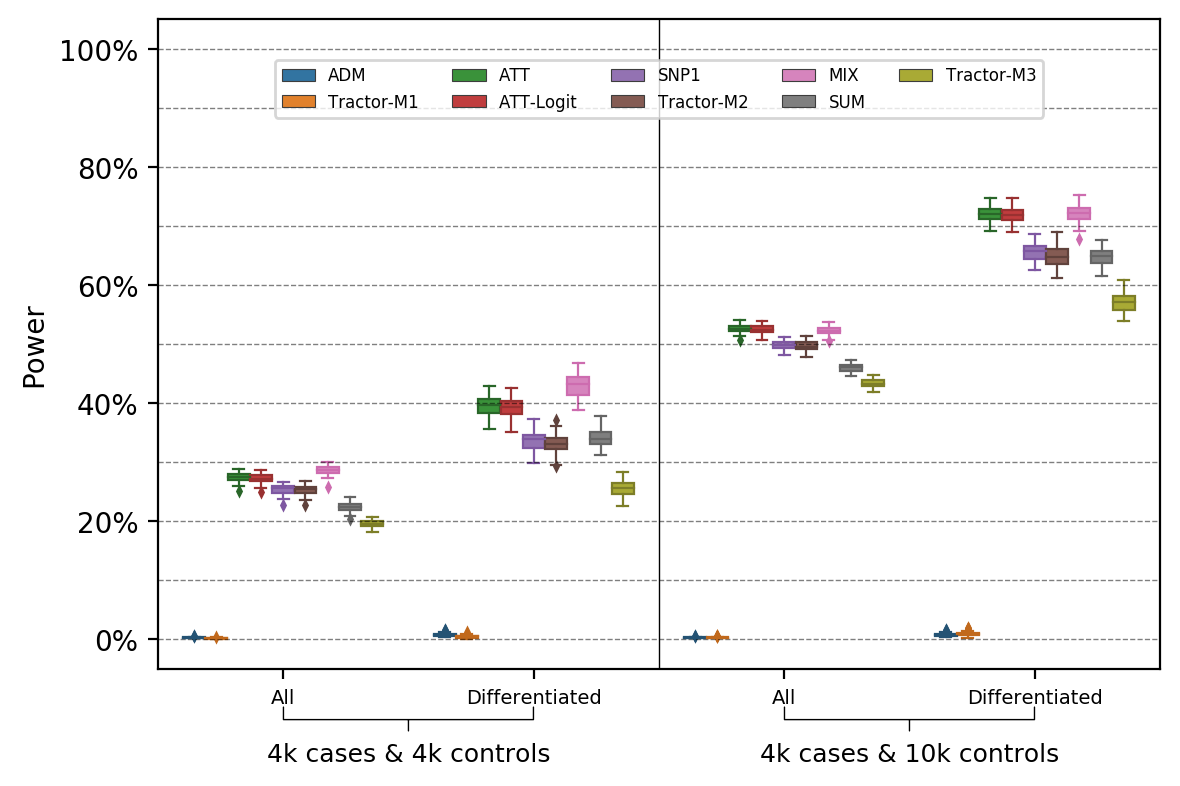

In [6]:
diff_snps = np.where(np.abs(legend.EUR.values - legend.AFR.values) > 0.2)[0]
print(f"Number of differentiated SNPs: {len(diff_snps)}")

odds_ratio = 1.2

pval_df_4k = score_df_dict[1.0][odds_ratio].copy().dropna()
pval_df_10k = score_df_dict[2.5][odds_ratio].copy().dropna()

df = {"score": [], "sig_prop": [], "sim_i": [], "control_size": [], "only_diff_snp": []}

for control_size, raw_pval_df in zip(["4k", "10k"], [pval_df_4k, pval_df_10k]):
    for only_diff_snp in [False, True]:
        if only_diff_snp:
            pval_df = raw_pval_df[raw_pval_df.SNP_I.isin(diff_snps)].copy()
        else:
            pval_df = raw_pval_df.copy()
        
        for score in pval_df.columns[0:-2]:
            p_threshold = 1e-5 if score in ["ADM", "ADM_LOGISTIC"] else 5e-8
            sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
            score_n_sim = len(sig_prop)
            df["score"].extend([score] * score_n_sim)
            df["sig_prop"].extend(sig_prop)
            df["sim_i"].extend(sig_prop.index.values)
            df["control_size"].extend([control_size] * score_n_sim)
            df["only_diff_snp"].extend([only_diff_snp] * score_n_sim)
            
df = pd.DataFrame(df)
df = df.replace({"ADM_LOGISTIC": "Tractor-M1",
                 "SNP1_LOGISTIC": "Tractor-M2",
                 "TRACTOR": "Tractor-M3",
                 "ATT_LOGISTIC": "ATT-Logit"})
df["xlabel"] = df.apply(lambda row: row["control_size"] + str(row["only_diff_snp"]), axis = 1)

# plotting
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
label_order = ["ADM", "Tractor-M1", "ATT", "ATT-Logit", "SNP1", "Tractor-M2",
                       "MIX", "SUM", "Tractor-M3"]

sns.boxplot(x="xlabel", y="sig_prop",
            hue="score",
            hue_order=label_order,
            width=0.8,
            linewidth=0.8,
            fliersize=2,
            data=df, ax=ax)


lighten_boxplot(ax)

ax.axvline(1.5, color='k', lw=0.5)
[ax.axhline(y=i, linestyle='--', color='k', alpha=0.5, lw=0.5) for i in np.linspace(0, 1, 11)]
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])

ax.annotate('4k cases & 4k controls', xy=(0.25, -0.07), xytext=(0.25, -0.15), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=0.5))

ax.annotate('4k cases & 10k controls', xy=(0.75, -0.07), xytext=(0.75, -0.15), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=0.5))
plt.xlabel("")
plt.ylabel("Power")
ax.set_xticklabels(["All", "Differentiated"] * 2, fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,0.95),
      ncol=5, fontsize=6)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig(f"manuscript/main.png", dpi=200, bbox_inches='tight')

# Full results

Number of differentiated SNPs: 904


## Control ratio: 1.0, only differentiated SNPs: False

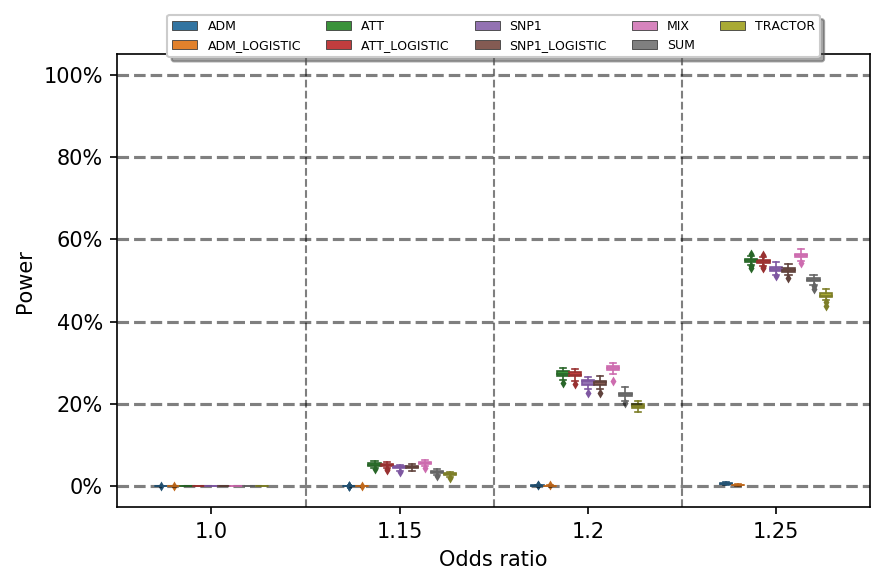

## Control ratio: 1.0, only differentiated SNPs: True

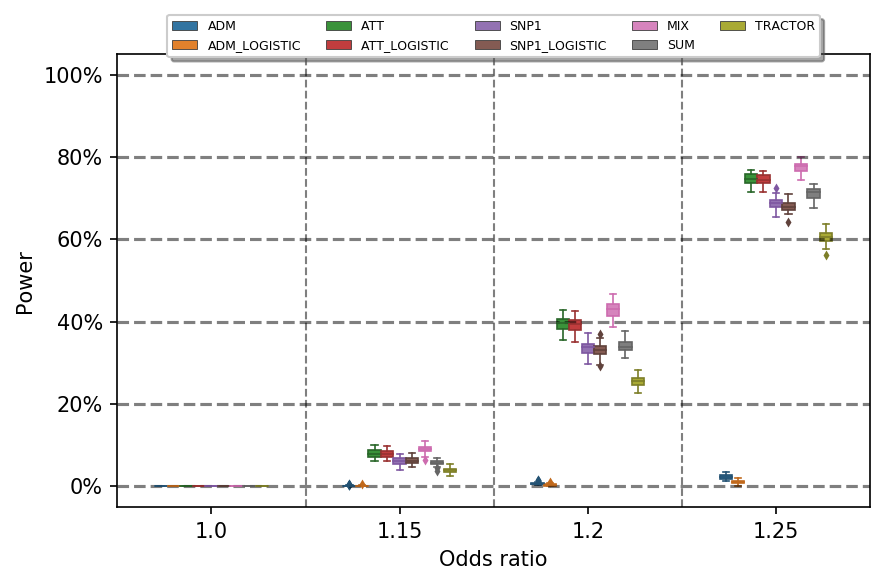

## Control ratio: 2.5, only differentiated SNPs: False

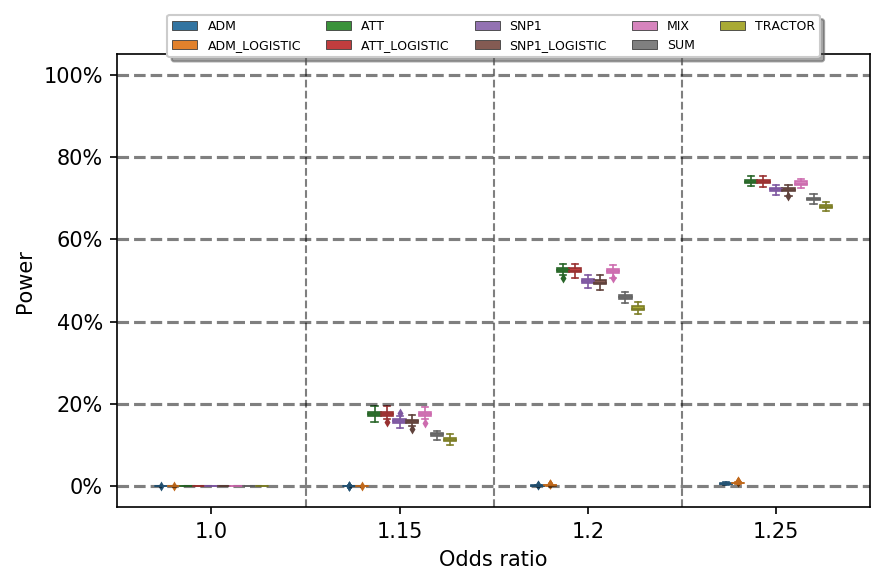

## Control ratio: 2.5, only differentiated SNPs: True

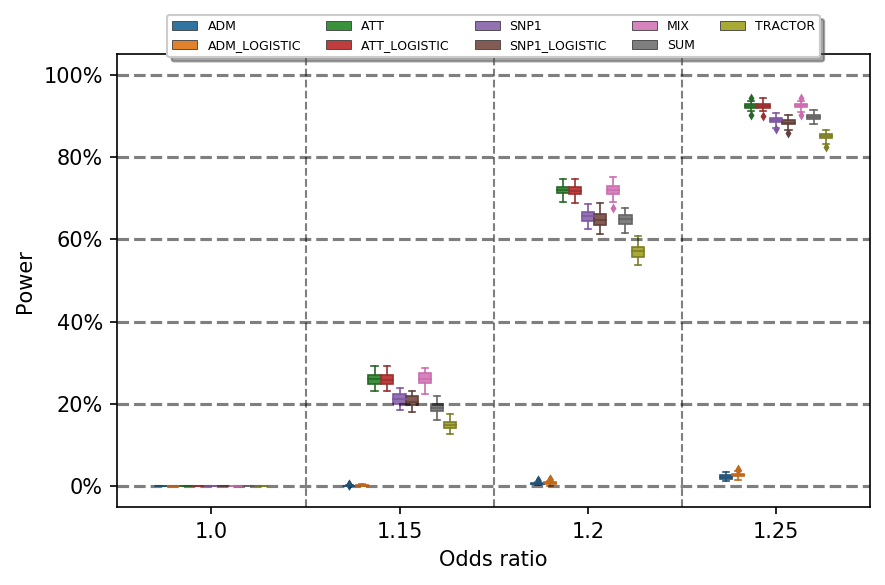

In [7]:
diff_snps = np.where(np.abs(legend.EUR.values - legend.AFR.values) > 0.2)[0]
print(f"Number of differentiated SNPs: {len(diff_snps)}")
for control_ratio in control_ratio_list:
    for only_diff_snp in [False, True]:
        display(Markdown(f"## Control ratio: {control_ratio}, only differentiated SNPs: {only_diff_snp}"))
        df = {"score": [], "odds_ratio": [], "sig_prop": [], "sim_i": []}
        for odds_ratio in odds_ratio_list:
            pval_df = score_df_dict[control_ratio][odds_ratio].copy().dropna()
            if only_diff_snp:
                pval_df = pval_df[pval_df.SNP_I.isin(diff_snps)]
            for score in pval_df.columns[0:-2]:
                p_threshold = 1e-5 if score in ["ADM", "ADM_LOGISTIC"] else 5e-8
                sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
                sig_prop_mean = np.mean(sig_prop)
                sig_prop_se = np.std(sig_prop) / np.sqrt(len(sig_prop))
                score_n_sim = len(sig_prop)
                df["score"].extend([score] * score_n_sim)
                df["odds_ratio"].extend([odds_ratio] * score_n_sim)
                df["sig_prop"].extend(sig_prop)
                df["sim_i"].extend(sig_prop.index.values)
        df = pd.DataFrame(df)
        
        pivotted = df.groupby(["score", "odds_ratio"])["sig_prop"].mean().reset_index().pivot(
            index=["odds_ratio"], columns='score')


        file_prefix = f"{geno_sim_prefix}.control_ratio_{control_ratio}.only_diff" if only_diff_snp else f"{geno_sim_prefix}.control_ratio_{control_ratio}"

        # plotting
        fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
        label_order = ["ADM", "ADM_LOGISTIC", "ATT", "ATT_LOGISTIC", "SNP1", "SNP1_LOGISTIC",
                               "MIX", "SUM", "TRACTOR"]
        sns.boxplot(x="odds_ratio", y="sig_prop",
                    hue="score",
                    hue_order=label_order,
                    width=0.6,
                    linewidth=0.8,
                    fliersize=2,
                    data=df, ax=ax)
        
        [ax.axvline(i + 0.5, color='k', alpha=0.5, linestyle='--', lw=1) for i in range(len(np.unique(df['odds_ratio'])) - 1)]
        lighten_boxplot(ax)
        [ax.axhline(y=i, linestyle='--', color='k', alpha=0.5) for i in np.linspace(0, 1, 6)]
        ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
        plt.xlabel("Odds ratio")
        plt.ylabel("Power")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=5, fancybox=True, shadow=True, fontsize=6)
        plt.ylim(-0.05, 1.05)
        plt.tight_layout()
        plt.savefig(f"manuscript/power/{file_prefix}.png", dpi=150)
        plt.show()

        pivotted.to_excel(f"manuscript/power/{file_prefix}.xlsx")